<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/05_simple_classification_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Simple Classification Problem

In a classification problem, we’re trying to predict which class a data
point belongs to.

Let’s say we have two classes of points: they are either red or blue. These are the
labels `(y)` of the points. 

Sure enough, we need to assign numeric values to them. We
could assign zero to red and one to blue. The class associated with zero is the
negative class, while one corresponds to the positive class.

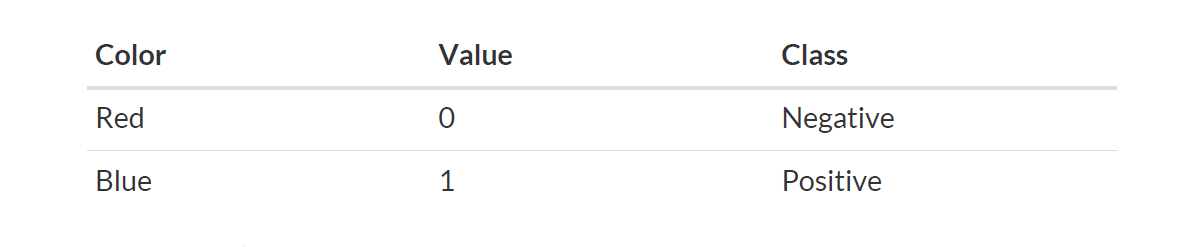

We can think of the logistic regression as the second simplest neural network
possible. It is pretty much the same as the linear regression, but with a sigmoid applied to the results of the output layer (`z`).

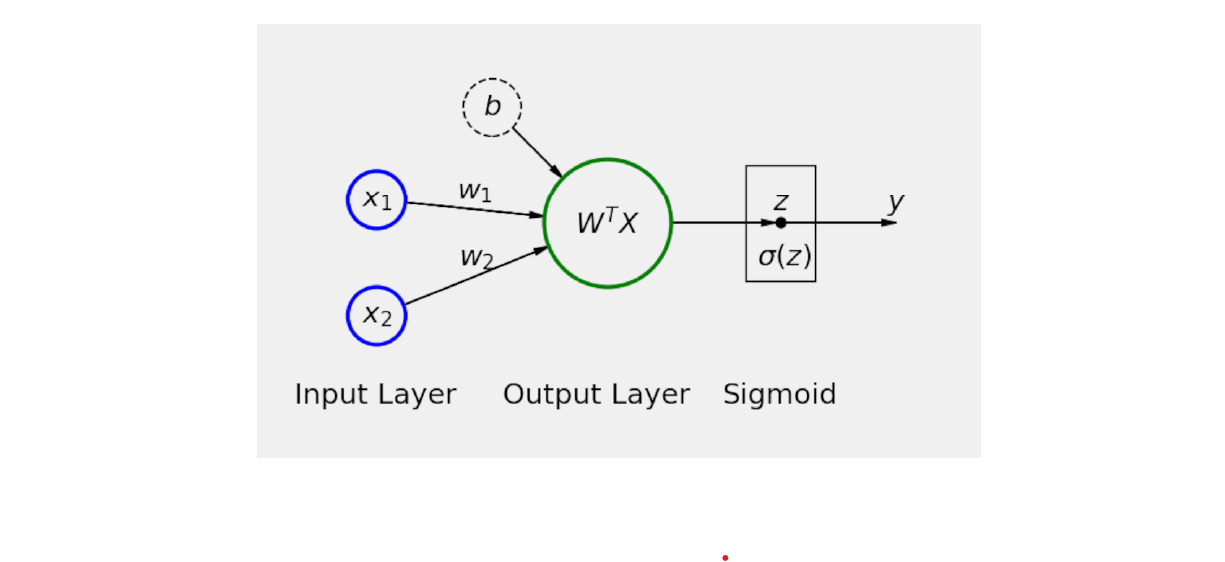

##Setup

In [ ]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter3()
# This is needed to render the plots in this chapter
from plots.chapter3 import *

In [ ]:
!wget https://github.com/rahiakela/deep-learning-research-and-practice/raw/main/deep-learning-with-pytorch-step-by-step/networks/trainer.py

In [3]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

from trainer import Trainer

##Data Generation

Let’s make the data a bit more interesting by using two features ($x_1$ and $x_2$) this time. 

We’ll use Scikit-Learn’s `make_moons` to generate a toy dataset with 100 data
points. We will also add some Gaussian noise and set a random seed to ensure
reproducibility.

In [4]:
X, y = make_moons(n_samples=100, noise=0.3, random_state=0)

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13) 

>Remember, the split should always be the first thing you do - no
preprocessing, no transformations, nothing happens before the
split.

Next, we’ll standardize the features using Scikit-Learn’s `StandardScaler`:

In [5]:
st_scaler = StandardScaler()
st_scaler.fit(x_train)  # use only the training set to fit

# then use its transform method to apply the preprocessing step to all datasets
x_train = st_scaler.transform(x_train)
x_val = st_scaler.transform(x_val)

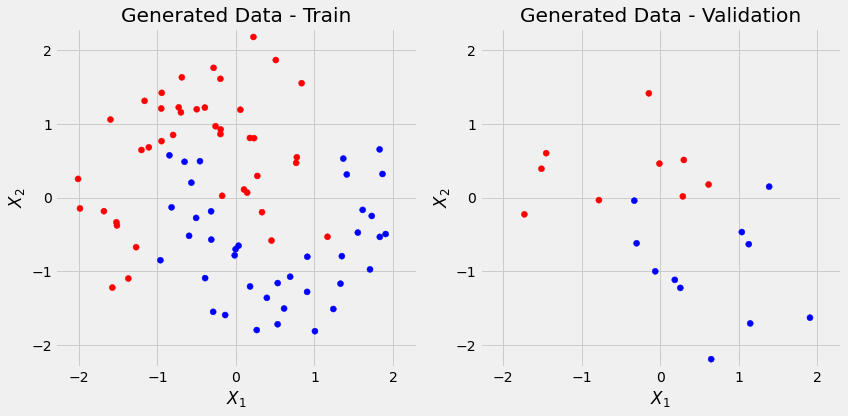

In [6]:
fig = figure1(x_train, y_train, x_val, y_val)

##Data Preparation

As usual, the data preparation
step converts Numpy arrays into PyTorch tensors, builds TensorDatasets for them,
and creates the corresponding data loaders.

In [7]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(x_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(x_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

## Logit Fundamentals

How would a linear regression model
with two features look like?

$$
\Large
y = b + w_1x_1 + w_2x_2 + \epsilon
$$

There is one obvious problem with the model above: our `labels (y)` are discrete;
that is, they are either zero or one; no other value is allowed. We need to change
the model slightly to adapt it to our purposes…

$$
\Large 
y =
\begin{cases}
1,\ \text{if }b + w_1x_1 + w_2x_2 \ge 0
\\
0,\ \text{if }b + w_1x_1 + w_2x_2 < 0
\end{cases}
$$

To make our lives easier, let’s give the right-hand side of the equation above a
name: `logit (z)`.

$$
\Large
z = b + w_1x_1 + w_2x_2
$$

There is one fundamental difference between them: there is no error
term (epsilon).

If there is no error term, where does the uncertainty come from?

That’s the role of the probability: instead of assigning a data
point to a discrete label (zero or one), we’ll compute the probability of a data point
belonging to the positive class.

We would like to have large positive logit values assigned
to higher probabilities (of being in the positive class) and large negative logit values
assigned to lower probabilities (of being in the positive class).

$$
\Large
\begin{aligned}
& \text{P}(y=1) \approx 1.0, & \text{if } &z \gg 0
\\
& \text{P}(y=1) = 0.5, & \text{if } &z = 0
\\
& \text{P}(y=1) \approx 0.0, & \text{if } &z \ll 0
\end{aligned}
$$




###Odd Ratio

Let’s imagine we are betting on the winner of the World Cup’s final. There are two
countries: A and B. 

Country A is the favorite: it has a 75% chance of winning.So, Country B has only a 25% chance of winning. 

If you bet on Country A, your chances
of winning, that is, your odds (in favor) are 3 to 1 (75 to 25). If you decide to test
your luck and bet on Country B, your chances of winning, that is, your odds (in
favor) are 1 to 3 (25 to 75), or 0.33 to 1.

The odds ratio is given by the ratio between the probability of success (`p`) and the
probability of failure (`q`):

$$
\Large \text{odds ratio }(p) = \frac{p}{q} = \frac{p}{1-p}
$$



In [8]:
def odds_ratio(prob):
  return prob / (1 - prob)

In [9]:
p = .75
q = 1 - p

odds_ratio(p), odds_ratio(q)

(3.0, 0.3333333333333333)

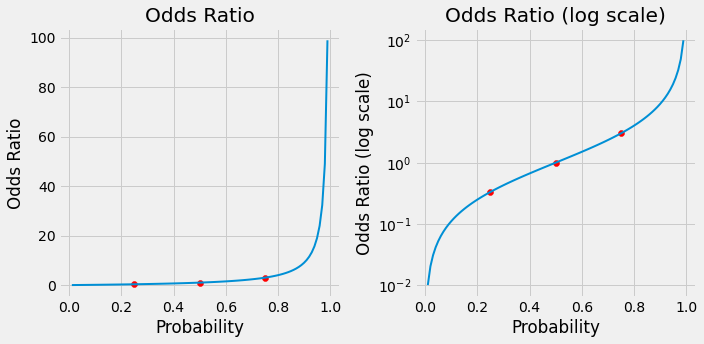

In [10]:
fig = figure2(p)

###Log Odds Ratio

By taking the logarithm of the odds ratio, the function is not only symmetrical, but
it also maps probabilities into real numbers, instead of only the positive ones:

$$
\Large \text{log odds ratio }(p) = \text{log}\left(\frac{p}{1-p}\right)
$$

In [11]:
def log_odds_ratio(prob):
  return np.log(prob / (1 - prob))

In [12]:
p = .75
q = 1 - p

log_odds_ratio(p), log_odds_ratio(q)

(1.0986122886681098, -1.0986122886681098)

As expected, probabilities that add up to `100%` (like `75%` and `25%`) correspond to log odds ratios that are the same in absolute value.

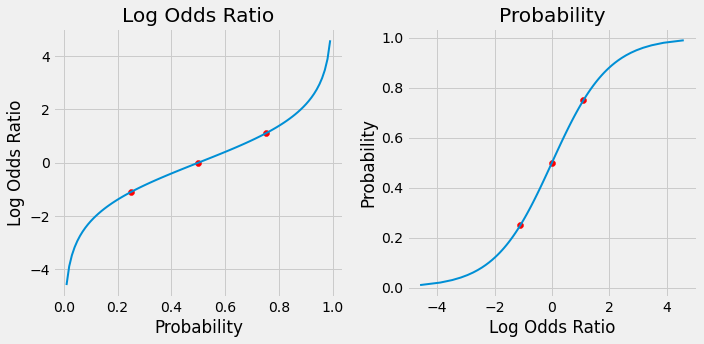

In [13]:
fig = figure3(p)

If we flip the horizontal and vertical axes (right plot), we are inverting the function, thus mapping each log odds ratio into a probability.

###From Logits to Probabilities

Clearly, our logits are log odds ratios :-) 

Sure, drawing conclusions like this is not
very scientific, but the purpose of this exercise is to illustrate how the results of a
regression, represented by the logits `(z)`, get to be mapped into probabilities.

$$
\Large
\begin{aligned}
b + w_1x_1 + w_2x_2 = &\ z = \text{log}\left(\frac{p}{1-p}\right) \nonumber
\\
e^{b + w_1x_1 + w_2x_2} = &\ e^z = \frac{p}{1-p} \nonumber
\end{aligned}
$$

Let’s work this equation out a bit, inverting, rearranging, and simplifying some
terms to isolate `p`:

$$
\Large
\begin{aligned}
\frac{1}{e^z}& = \frac{1-p}{p}
\\
e^{-z}& = \frac{1}{p} - 1
\\
1 + e^{-z}& = \frac{1}{p}&
\\
p& = \frac{1}{1 + e^{-z}}
\end{aligned}
$$

That’s a sigmoid function! It is the inverse of the log odds
ratio.

$$
\Large
p = \sigma(z) = \frac{1}{1+e^{-z}}
$$

In [14]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

In [15]:
p = .75
q = 1 - p

sigmoid(log_odds_ratio(p)), sigmoid(log_odds_ratio(q))

(0.75, 0.25)

###Sigmoid

PyTorch provides
two different ways of using a sigmoid: `torch.sigmoid` and `nn.Sigmoid`.

In [16]:
# The first one is a simple function, but taking a tensor as input and returning another tensor
torch.sigmoid(torch.tensor(1.0986)), torch.sigmoid(torch.tensor(-1.0986))

(tensor(0.7500), tensor(0.2500))

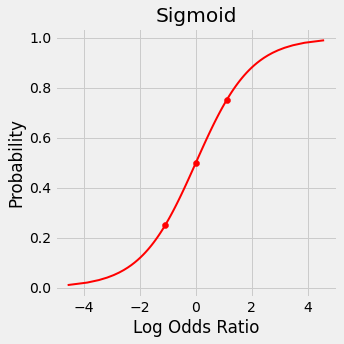

In [17]:
fig = figure4(p)

###Logistic Regression

Given two features, $x_1$ and $x_2$, the model will fit a linear regression such that its
outputs are logits (`z`), which are converted into probabilities using a sigmoid function.

$$
\Large
\text{P}(y=1) = \sigma(z) = \sigma(b+w_1x_1+w_2x_2)
$$

Now let’s use the Sequential model to build our logistic regression.

In [18]:
torch.manual_seed(42)

model1 = nn.Sequential()
model1.add_module("linear", nn.Linear(2, 1))
model1.add_module("sigmoid", nn.Sigmoid())

print(model1.state_dict())

OrderedDict([('linear.weight', tensor([[0.5406, 0.5869]])), ('linear.bias', tensor([-0.1657]))])


Let's understand its vectorized representations.

Dataset:

$$
\Large W =
\underset{(3 \times 1)}{
\begin{bmatrix}
b \\
w_1 \\
w_2
\end{bmatrix}};
X = 
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
$$

Model:

$$
\Large 
\begin{aligned}
z
& = W^T X
=
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
= \underset{(1 \times 3)}{
\begin{bmatrix}
b & w_1 & w_2
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}\\
& = b + w_1x_1 + w_2x_2
\end{aligned}
$$

##Loss

A binary classification problem calls for the binary cross-entropy (BCE) loss,
sometimes known as log loss.

The BCE loss requires the predicted probabilities, as returned by the sigmoid
function, and the true `labels (y)` for its computation.

If the data point belongs to the positive `class (y=1)`, we would like our model to predict a probability close to one, right? 

A perfect one would result in the logarithm of one, which is zero. It makes sense; a perfect prediction means zero loss.

$$
\Large y_i = 1 \Rightarrow \text{error}_i=\text{log}(\text{P}(y_i=1))
$$

What if the data point belongs to the negative `class (y=0)`? 

Then we cannot simply
use the predicted probability. Why not? 

Because the model outputs the probability
of a point belonging to the positive, not the negative, class.

$$
\Large \text{P}(y_i=0)=1-\text{P}(y_i=1)
$$

And thus, the error associated with a data point belonging to the negative class
goes like this:

$$
\Large y_i = 0 \Rightarrow \text{error}_i=\text{log}(1-\text{P}(y_i=1))
$$

Once all errors are computed, they are aggregated into a loss value. 

For the
binary-cross entropy loss, we simply take the average of the errors and invert its sign.

$$
\Large
\text{BCE}(y)={-\frac{1}{(N_{\text{pos}}+N_{\text{neg}})}\Bigg[{\sum_{i=1}^{N_{\text{pos}}}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_{\text{neg}}}{\text{log}(1 - \text{P}(y_i=1))}}\Bigg]}
$$

Let’s assume we have two dummy data points, one for each class. Then, let’s
pretend our model made predictions for them: `0.9` and `0.2`. 

The predictions are not
bad since it predicts a `90%` probability of being positive for an actual positive, and
only `20%` of being positive for an actual negative.

In [19]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# Positive class (labels == 1)
positive_pred = dummy_predictions[dummy_labels == 1]
first_summation = torch.log(positive_pred).sum()

# Negative class (labels == 0)
negative_pred = dummy_predictions[dummy_labels == 0]
second_summation = torch.log(1 - negative_pred).sum()

# n_total = n_pos + n_neg
n_total = dummy_labels.size(0)

loss = -(first_summation + second_summation) / n_total
loss

tensor(0.1643)

believe the formula above is quite straightforward and easy to
understand. 

Unfortunately, it is usually skipped over, and only its equivalent is
presented:

$$
\Large
\text{BCE}(y)={-\frac{1}{N}\sum_{i=1}^{N}{\left[y_i \text{log}(\text{P}(y_i=1)) + (1-y_i) \text{log}(1-\text{P}(y_i=1))\right]}}
$$

If you pause for a
minute, you’ll realize that points in the positive `class (y=1)` have its second term equals zero, while points in the negative `class (y=0)` have its first term equals zero.

In [20]:
summation = torch.sum(dummy_labels * torch.log(dummy_predictions) + (1 - dummy_labels) * torch.log(1- dummy_predictions))

loss = - summation / n_total
loss

tensor(0.1643)

Of course, we got the same loss `(0.1643)` as before.

**Reference**

[Understanding binary cross-entropy / log loss: a visual explanation](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)

###BCELoss

Sure enough, PyTorch implements the binary cross-entropy loss, `nn.BCELoss`.
It is a higher-order
function that returns the actual loss function.

In [21]:
loss_fn = nn.BCELoss()
loss_fn

BCELoss()

>IMPORTANT: make sure to pass the predictions first and then
the labels to the loss function. The order matters in the
implementation of this loss function.

In [22]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# RIGHT
right_loss = loss_fn(dummy_predictions, dummy_labels)

# WRONG
wrong_loss = loss_fn(dummy_labels, dummy_predictions)

print(right_loss, wrong_loss)

tensor(0.1643) tensor(15.0000)


###BCEWithLogitsLoss

The former loss function took probabilities as an argument (together with the
labels, obviously). This loss function takes logits as an argument, instead of
probabilities.

It means you should NOT add a sigmoid as the last layer of your model when using
this loss function. This loss combines both the sigmoid layer and the former binary
cross-entropy loss into one.

In [23]:
loss_fn_logits = nn.BCEWithLogitsLoss()
loss_fn_logits

BCEWithLogitsLoss()

Next, we use logits and labels to compute the loss.

In [24]:
logit1 = log_odds_ratio(.9)
logit2 = log_odds_ratio(.2)

dummy_labels = torch.tensor([1.0, 0.0])
dummy_logits = torch.tensor([logit1, logit2])
print(dummy_logits)

tensor([ 2.1972, -1.3863], dtype=torch.float64)


We have logits, and we have labels. Time to compute the loss:

In [25]:
loss = loss_fn_logits(dummy_logits, dummy_labels)
loss

tensor(0.1643)

OK, we got the same result, as expected.

###Imbalanced Dataset

Let’s create another dummy example
with an imbalance, adding two extra data points belonging to the negative class.

For the sake of simplicity and to illustrate a quirk in the behavior of
`BCEWithLogitsLoss`, I will give those two extra points the same logits as the other
data point in the negative class.

In [26]:
dummy_imb_labels = torch.tensor([1.0, 0.0, 0.0, 0.0])
dummy_imb_logits = torch.tensor([logit1, logit2, logit2, logit2])

Clearly, this is an imbalanced dataset. There are three times more data points in
the negative class than in the positive one. 

Now, let’s turn to the pos_weight
argument of BCEWithLogitsLoss. 

To compensate for the imbalance, one can set the
weight equals the ratio of negative to positive examples:

$$
\Large \text{pos_weight} = \frac{\text{# points in negative class}}{\text{# points in positive class}}
$$

In our imbalanced dummy example, the result would be 3.0.



In [27]:
n_neg = (dummy_imb_labels == 0).sum().float()
n_pos = (dummy_imb_labels == 1).sum().float()

pos_weight = (n_neg / n_pos).view(1,)
pos_weight

tensor([3.])

Now, let’s create yet another loss function, including the `pos_weight` argument this
time:

In [28]:
loss_fn_imb = nn.BCEWithLogitsLoss(reduction="mean", pos_weight=pos_weight)

I guess one would expect the same loss as before; after all,
this is a weighted loss. Right?

In [29]:
loss = loss_fn_imb(dummy_imb_logits, dummy_imb_labels)
loss

tensor(0.2464)

Wrong! It was `0.1643` when we had two data points, one of each class.

Well, it turns out, PyTorch does not compute a weighted average. That’s what you
would expect from a weighted average:

$$
\Large \text{weighted average} = \frac{\text{pos_weight} \sum_{i=1}^{N_{\text{pos}}}{\text{loss}_i}+\sum_{i=1}^{N_{\text{neg}}}{\text{loss}_i}}{\text{pos_weight} N_{\text{pos}}+N_{\text{neg}}}
$$

But this is what PyTorch does:

$$
\Large \text{BCEWithLogitsLoss} = \frac{\text{pos_weight} \sum_{i=1}^{N_{\text{pos}}}{\text{loss}_i}+\sum_{i=1}^{N_{\text{neg}}}{\text{loss}_i}}{N_{\text{pos}}+N_{\text{neg}}}
$$

See the difference in the denominator? 

Of course, if you multiply the losses of the
positive examples without multiplying their `count (N)`, you’ll end up with a number
larger than an actual weighted average.

Remember the reduction argument? 

If we set it to
sum, our loss function will only return the numerator of the equation above.

In [30]:
loss_fn_imb_sum = nn.BCEWithLogitsLoss(reduction="sum", pos_weight=pos_weight)

loss = loss_fn_imb_sum(dummy_imb_logits, dummy_imb_labels)

loss = loss / (pos_weight * n_pos + n_neg)
loss

tensor([0.1643])

##Model Training

Let’s define a model
that produces logits and use `BCEWithLogitsLoss` as the loss function.

In [31]:
# Sets learning rate
lr = 0.1

torch.manual_seed(42)

model = nn.Sequential()
model.add_module("linear", nn.Linear(2, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE with logits loss function
loss_fn = nn.BCEWithLogitsLoss()

In [32]:
# let's train our model
n_epochs = 100

trainer = Trainer(model, loss_fn, optimizer)
trainer.set_loaders(train_loader, val_loader)
trainer.train(n_epochs)

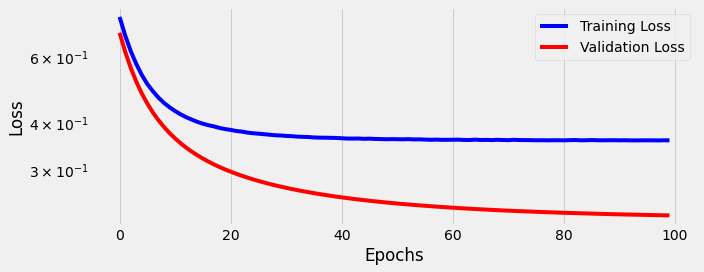

In [33]:
fig = trainer.plot_losses()

In [34]:
# inspect the model’s trained parameters
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[ 1.1806, -1.8693]])), ('linear.bias', tensor([-0.0591]))])


Our model produced logits, right? So we can plug the weights above in the
corresponding logit equation.

$$
\large
\begin{array}{ccccccc}
z & = & b & + & w_1x_1 & + & w_2x_2
\\
z & = & -0.0587 & + & 1.1822x_1 & - & 1.8684x_2
\end{array}
$$

The value z above is the output of our model. It is a "glorified linear regression"!

And this is a classification problem!

If I would like to use our model to make predictions for, say, the first four data points in our
training set:

In [35]:
predictions = trainer.predict(x_train_tensor[:4])
predictions

array([[ 0.20345592],
       [ 2.9444451 ],
       [ 3.6933177 ],
       [-1.2334073 ]], dtype=float32)

Clearly, these are not probabilities, right? These are logits, as expected.

How do we go from logits to probabilities?

That’s what the sigmoid function is good for.

In [36]:
probabilities = sigmoid(predictions)
probabilities

array([[0.5506892 ],
       [0.9500003 ],
       [0.9757152 ],
       [0.22558564]], dtype=float32)

These are the probabilities, given our model, of those four
points being positive examples.

Lastly, we need to go from probabilities to classes. If the probability is greater than
or equal to a threshold, it is a positive example. If it is less than the threshold, it is a
negative example.

$$
\Large y =
\begin{cases}
1,\ \text{if P}(y=1) \ge 0.5
\\
0,\ \text{if P}(y=1) < 0.5
\end{cases}
$$

But the probability itself is just the sigmoid function applied to the `logit(z)`:

$$
\Large y =
\begin{cases}
1,\ \text{if } \sigma(z) \ge 0.5
\\
0,\ \text{if } \sigma(z) < 0.5
\end{cases}
$$

But the sigmoid function has a value of `0.5` only when the `logit(z)` has a value of
zero:

$$
\Large y =
\begin{cases}
1,\ \text{if } z \ge 0
\\
0,\ \text{if } z < 0
\end{cases}
$$

Thus, if we don’t care about the probabilities, we could use the `predictions(logits)`
directly to get the predicted classes for the data points:

In [37]:
classes = (predictions >= 0).astype(np.int32)
classes

array([[1],
       [1],
       [1],
       [0]], dtype=int32)

Clearly, the points where the `logits(z)` equal zero determine the boundary
between positive and negative examples.

By the way, are you still holding that thought about the "glorified linear regression"?

##Classification Threshold

So far, we’ve been using the trivial threshold of `50%` to classify our data points,
given the probabilities predicted by our model. 

Let’s dive a bit deeper into this and
see the effects of choosing different thresholds.

First, let’s compute the logits and corresponding probabilities:

In [38]:
logits_val = trainer.predict(x_val)
probabilities_val = sigmoid(logits_val).squeeze()

threshold = 0.5

Then, let’s visualize the probabilities on a line.

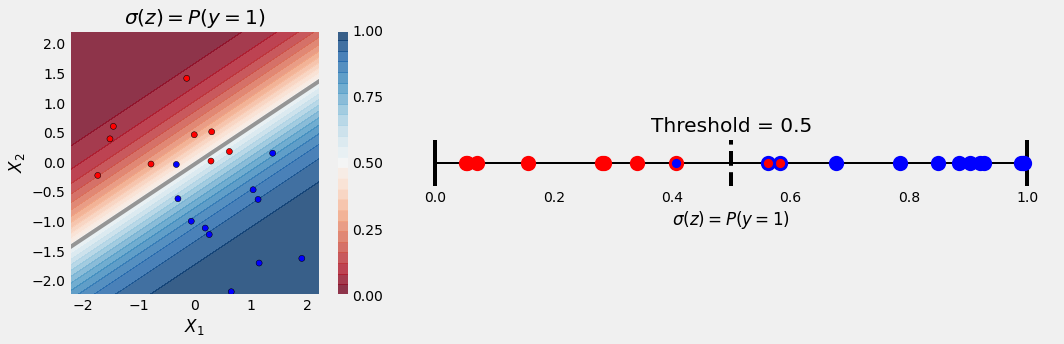

In [39]:
fig = figure9(x_val, y_val, trainer.model, trainer.device, probabilities_val, threshold)

As we see, we have one blue
point classified as red (left) and two red points classified as blue (right).

Now, let’s make a tiny change to our plot to make it more visually interesting: we’ll
plot blue (positive) points below the probability line and red (negative) points
above the probability line.

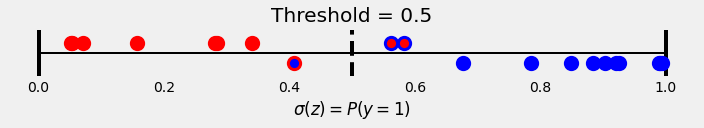

In [40]:
fig = figure10(y_val, probabilities_val, threshold, 0.04, False)

Well, now all correctly classified and all misclassified points are in different
quadrants.

###Confusion Matrix

Those quadrants have names: true negative (TN) and false positive (FP), above the
line, false negative (FN) and true positive (TP), below the line.

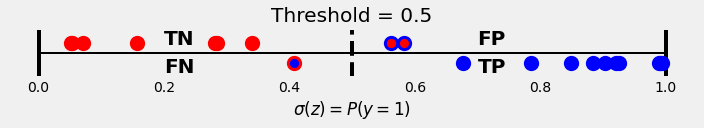

In [41]:
fig = figure10(y_val, probabilities_val, threshold, 0.04, True)

Points above the line are actual negatives, points below the line are actual positives.

Points to the right of the threshold are classified as positive, points to the left of the threshold are classified as negative.

Let’s double-check it.

In [42]:
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))
cm_thresh50

array([[ 7,  2],
       [ 1, 10]])

There are three misclassified
points: one false negative and two false positives.

There is one more thing I hope you noticed already: the confusion matrix depends
on the threshold. If you shift the threshold along the probability line, you’ll end up
changing the number of points in each quadrant.

There are many confusion matrices, one for each threshold.

Moreover, different confusion matrices mean different metrics. We need the
individual components of the confusion matrix, namely, TN, FP, FN, and TP, to
construct those metrics. 

The function below splits the confusion matrix
accordingly:



In [43]:
def split_cm(cm):
  # Actual negatives go in the top row, above the probability line
  actual_negative = cm[0]

  # Predicted negatives go in the first column
  tn = actual_negative[0]

  # Predicted positives go in the second column
  fp = actual_negative[1]

  # Actual positives go in the bottow row, below the probability line
  actual_positive = cm[1]

  # Predicted negatives go in the first column
  fn = actual_positive[0]

  # Predicted positives go in the second column
  tp = actual_positive[1]

  return tn, fp, fn, tp

###Metrics

Starting with these four numbers, TN, FP, FN, and TP, you may construct a ton of
metrics. 

We’re focusing here on the most commonly used: True and False Positive
Rates (TPR and FPR), precision, recall, and accuracy.

$$
\Large \text{TPR} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{FPR} = \frac{\text{FP}}{\text{FP + TN}}
$$

The true positive rate tells you, from all points you know to be positive, how many
your model got right.

There is yet another name for this metric: recall.

From all the positive examples, how many does your model recall?

In [44]:
def tpr_fpr(cm):
  tn, fp, fn, tp = split_cm(cm)

  tpr = tp / (tp + fn)
  fpr = fp / (fp + tn)
  return tpr, fpr

In [45]:
tpr_fpr(cm_thresh50)

(0.9090909090909091, 0.2222222222222222)

###Precision and Recall

$$
\Large \text{Recall} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{Precision} = \frac{\text{TP}}{\text{TP + FP}}
$$

In [46]:
def precision_recall(cm):
  tn, fp, fn, tp = split_cm(cm)

  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  return precision, recall

In [47]:
precision_recall(cm_thresh50)

(0.8333333333333334, 0.9090909090909091)

###Accuracy

This is the simplest and most intuitive of them all: how many times your model got
it right, considering all data points.

$$
\Large \text{Accuracy} = \frac{\text{TP+TN}}{\text{TP+TN+FP+FN}}
$$

If you have an imbalanced dataset, relying on accuracy can be
misleading.

In [48]:
tn, fp, fn, tp = split_cm(cm_thresh50)

accuracy = (tp + tn) / (tp + tn + fp + fn)

accuracy

0.85

###Metric Trade-offs

We already know there are trade-offs between true and false positive rates, as well
as between precision and recall.

What if we combine these two pieces of
information? 

I present to you the Receiver Operating Characteristic (ROC) and
Precision-Recall (PR) curves!

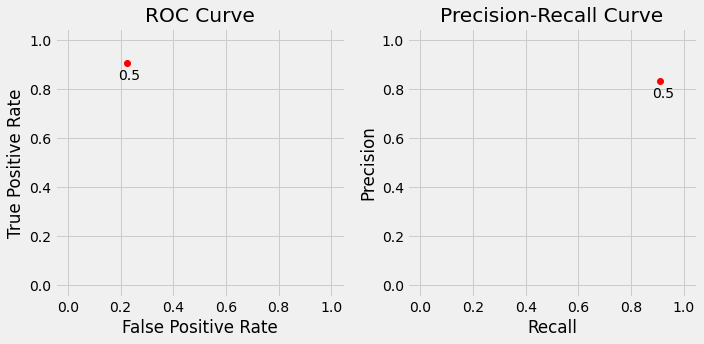

In [49]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.5], annot=True)

####Low Threshold

What about 30%? 

If the predicted probability is greater than or equal to 30%, we
classify the data point as positive, and as negative otherwise.

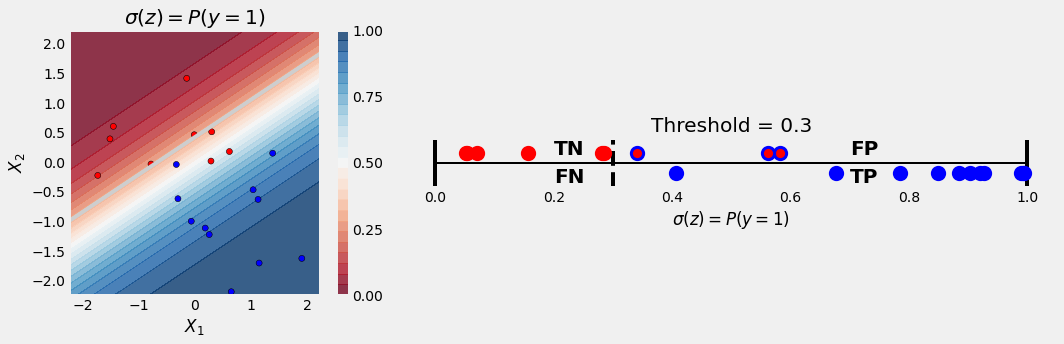

In [50]:
fig = figure9(x_val, y_val, trainer.model, trainer.device, probabilities_val, threshold=0.3, shift=0.04, annot=True)

You can see that lowering the threshold turned one false negative into a true positive (blue point
close to 0.4), but it also turned one true negative into a false positive (red point
close to 0.4).

Let’s double-check it.

In [51]:
confusion_matrix(y_val, (probabilities_val >= 0.3))

array([[ 6,  3],
       [ 0, 11]])

OK, now let’s plot the corresponding metrics.

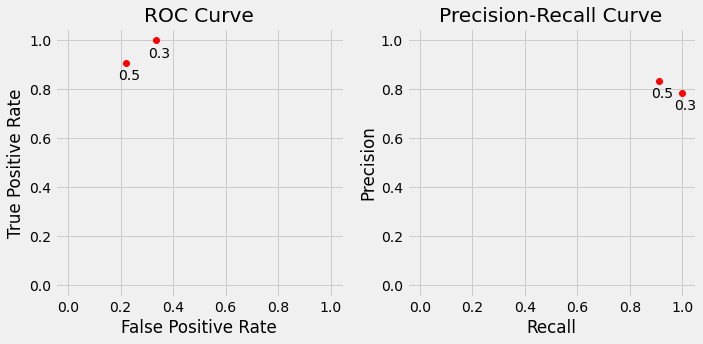

In [52]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.3, .5], annot=True)

**Lowering the threshold moves you to the right along both
curves.**

####High Threshold

What about `70%`? 

If the predicted probability is greater than or equal to `70%`, we
classify the data point as positive, and as negative otherwise.

What can we expect from it? 

Less false positives, more false
negatives.

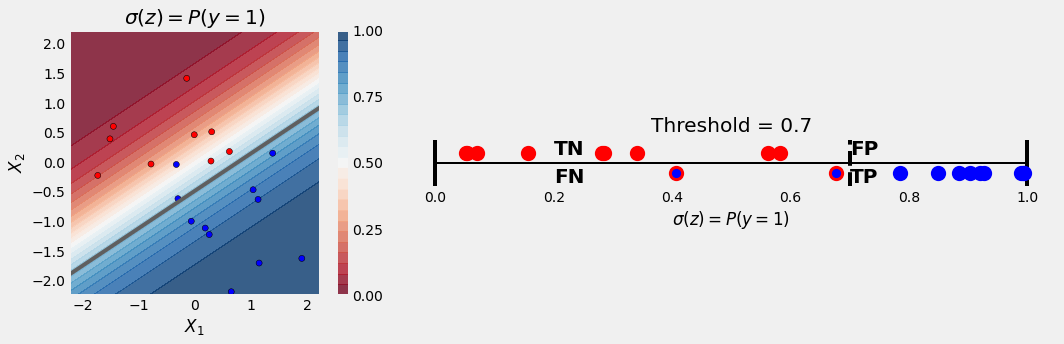

In [53]:
fig = figure9(x_val, y_val, trainer.model, trainer.device, probabilities_val, threshold=0.7, shift=0.04, annot=True)

You can see that raising the threshold turned two false positives into true negatives (red points
close to 0.6), but it also turned one true positive into a false negative (blue point
close to 0.6).

Let’s double-check it.

In [54]:
confusion_matrix(y_val, (probabilities_val >= 0.7))

array([[9, 0],
       [2, 9]])

OK, now let’s plot the corresponding metrics,

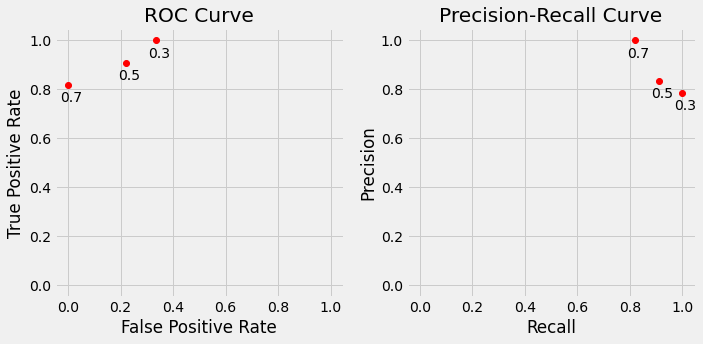

In [55]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.3, .5, .7], annot=True)

**Raising the threshold moves you to the left along both curves.**

####ROC and PR Curves

We need to try out more thresholds to actually build a curve. 

Let’s try multiples of `10%`:

In [56]:
threshs = np.linspace(0.0, 1, 11)

/content/plots/chapter3.py:49: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


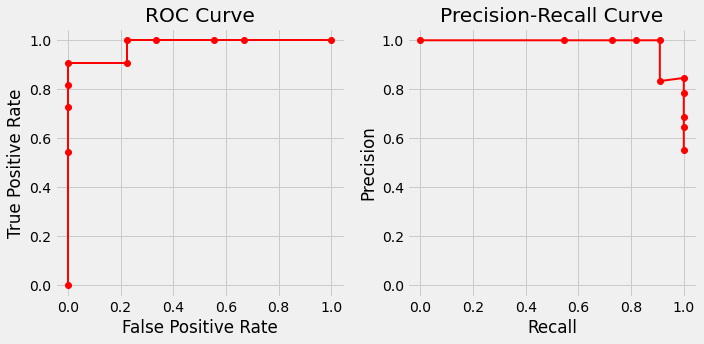

In [57]:
fig = figure17(y_val, probabilities_val, threshs)

Now, let’s double-check our curves.

In [58]:
fpr, tpr, thresholds1 = roc_curve(y_val, probabilities_val)
prec, rec, thresholds2 = precision_recall_curve(y_val, probabilities_val)

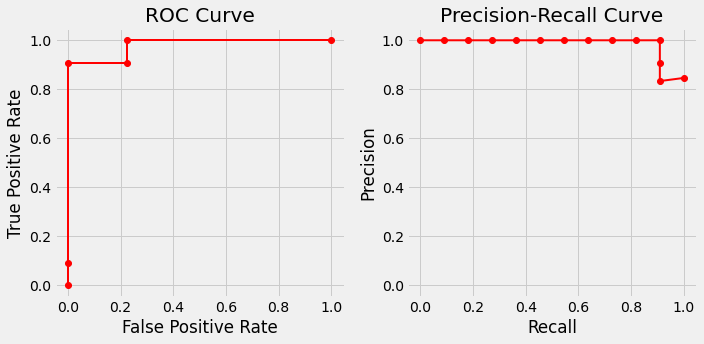

In [60]:
fig = eval_curves(fpr, tpr, rec, prec, thresholds1, thresholds2, line=True)

Why do these curves have different points than ours?

To illustrate why this happens, I will
plot the probability lines for three distinct thresholds: `0.4, 0.5`, and `0.57`.

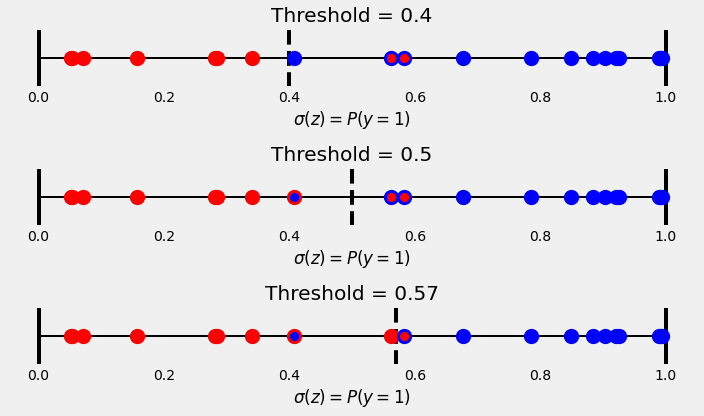

In [61]:
fig = figure19(y_val, probabilities_val)

At the top, with a threshold of `0.4`, we have `15` points on the right (classified as positive), two of which are false positives.

The precision is given by:

$$
\Large \text{Precision}(\text{thresh}=0.40)=\frac{13}{13+2}=0.8666
$$

But if we move the threshold to the right, up to `0.5`, we lose one true positive,
effectively reducing precision:

$$
\Large \text{Precision}(\text{thresh}=0.50)=\frac{(13-1)}{(13-1)+2}=\frac{12}{12+2}=0.8571
$$

This is a temporary side effect, though. 

As we raise the threshold even further to
`0.57`, we get the benefit of getting rid of a false positive, thus increasing precision:

$$
\Large \text{Precision}(\text{thresh}=0.57)=\frac{12}{12+(2-1)}=\frac{12}{12+1}=0.9230
$$

>In general, raising the threshold will reduce the number of false
positives and increase precision.
But, along the way, we may lose some of the true positives,
which will temporarily reduce precision.




